In [1]:
# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

# Import necessary libraries for plotting and data manipulation
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as path_effects
from IPython.display import HTML
import re
import matplotlib.cm as cm
from matplotlib.colors import TwoSlopeNorm

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Set default matplotlib font and font size
typeface = 'Arial'

# Update matplotlib parameters for consistent styling
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.family'] = typeface
mpl.rcParams['font.size'] = 22

# Notify the user that the setup is complete
print('Done!')


Done!


In [2]:
#IMPORT PREDICTOR MATRICES   


# dtypes_path = "C:/Users/iblag/Desktop/segment4_final1.xml"
dtypes_path = "C:/Users/iblag/Desktop/segment4_final_all.xml"


# Extract district codes from XML
xml_districts = []
read_loc = False


with open(dtypes_path, 'r') as f:
    for line in f:
        if 'state.dataType' in line:
            read_loc = True
        cerberus = re.search(r'<state code="([A-Za-z_]+)"/>', line)
        if read_loc and cerberus is not None:
            xml_districts.append(cerberus.group(1))

print('Number of datatypes: %d' % len(xml_districts))
print(xml_districts)

# Matrix indexing
matrix_index = {}
lg = len(xml_districts)
for i in range(len(xml_districts)):
    for j in range(i + 1, len(xml_districts)):
        f1 = int((lg * (lg - 1) / 2) - (lg - i) * ((lg - i) - 1) / 2 + j - i - 1)
        f2 = int((lg * (lg - 1)) - (lg - i) * ((lg - i) - 1) / 2 + j - i - 1)

        matrix_index[f1] = (xml_districts[i], xml_districts[j])
        matrix_index[f2] = (xml_districts[j], xml_districts[i])

# Extract predictor matrices and descriptions
predictor_matrices = {}
predictor_description = {}
counter = 0
description_comment = ''
store = ''
pattern = re.compile(r'\t+<parameter id="([A-Za-z0-9_.]+)" value="([0-9.\- E]+)"\s*/>')
design_matrix=0

with open(dtypes_path, 'r') as f:
    for line in f:
        if '<designMatrix' in line:
            design_matrix=1
        if design_matrix:
            # Find matrix
            matrix = pattern.search(line)
            if matrix is not None:
                predictor = matrix.group(1)
                # Convert the matrix values to a list of floats
                float_matrix = list(map(float, matrix.group(2).strip().split()))
                # Check if the length of the matrix matches the expected size
                if len(float_matrix) == ((len(xml_districts))**2 - len(xml_districts)):
                    predictor_matrices[predictor] = float_matrix
                    counter += 1


print(f'\npredictors found in file: {counter}')
print(f'predictor matrices: {len(predictor_matrices)}')

Number of datatypes: 14
['Australia', 'Canada', 'China', 'Denmark', 'France', 'Italy', 'Japan', 'Mexico', 'Namibia', 'Netherlands', 'Sweden', 'Turkey', 'USA', 'United_Kingdom']

predictors found in file: 23
predictor matrices: 23


state.capital_distance_km_offsetlog 46.34377675316775


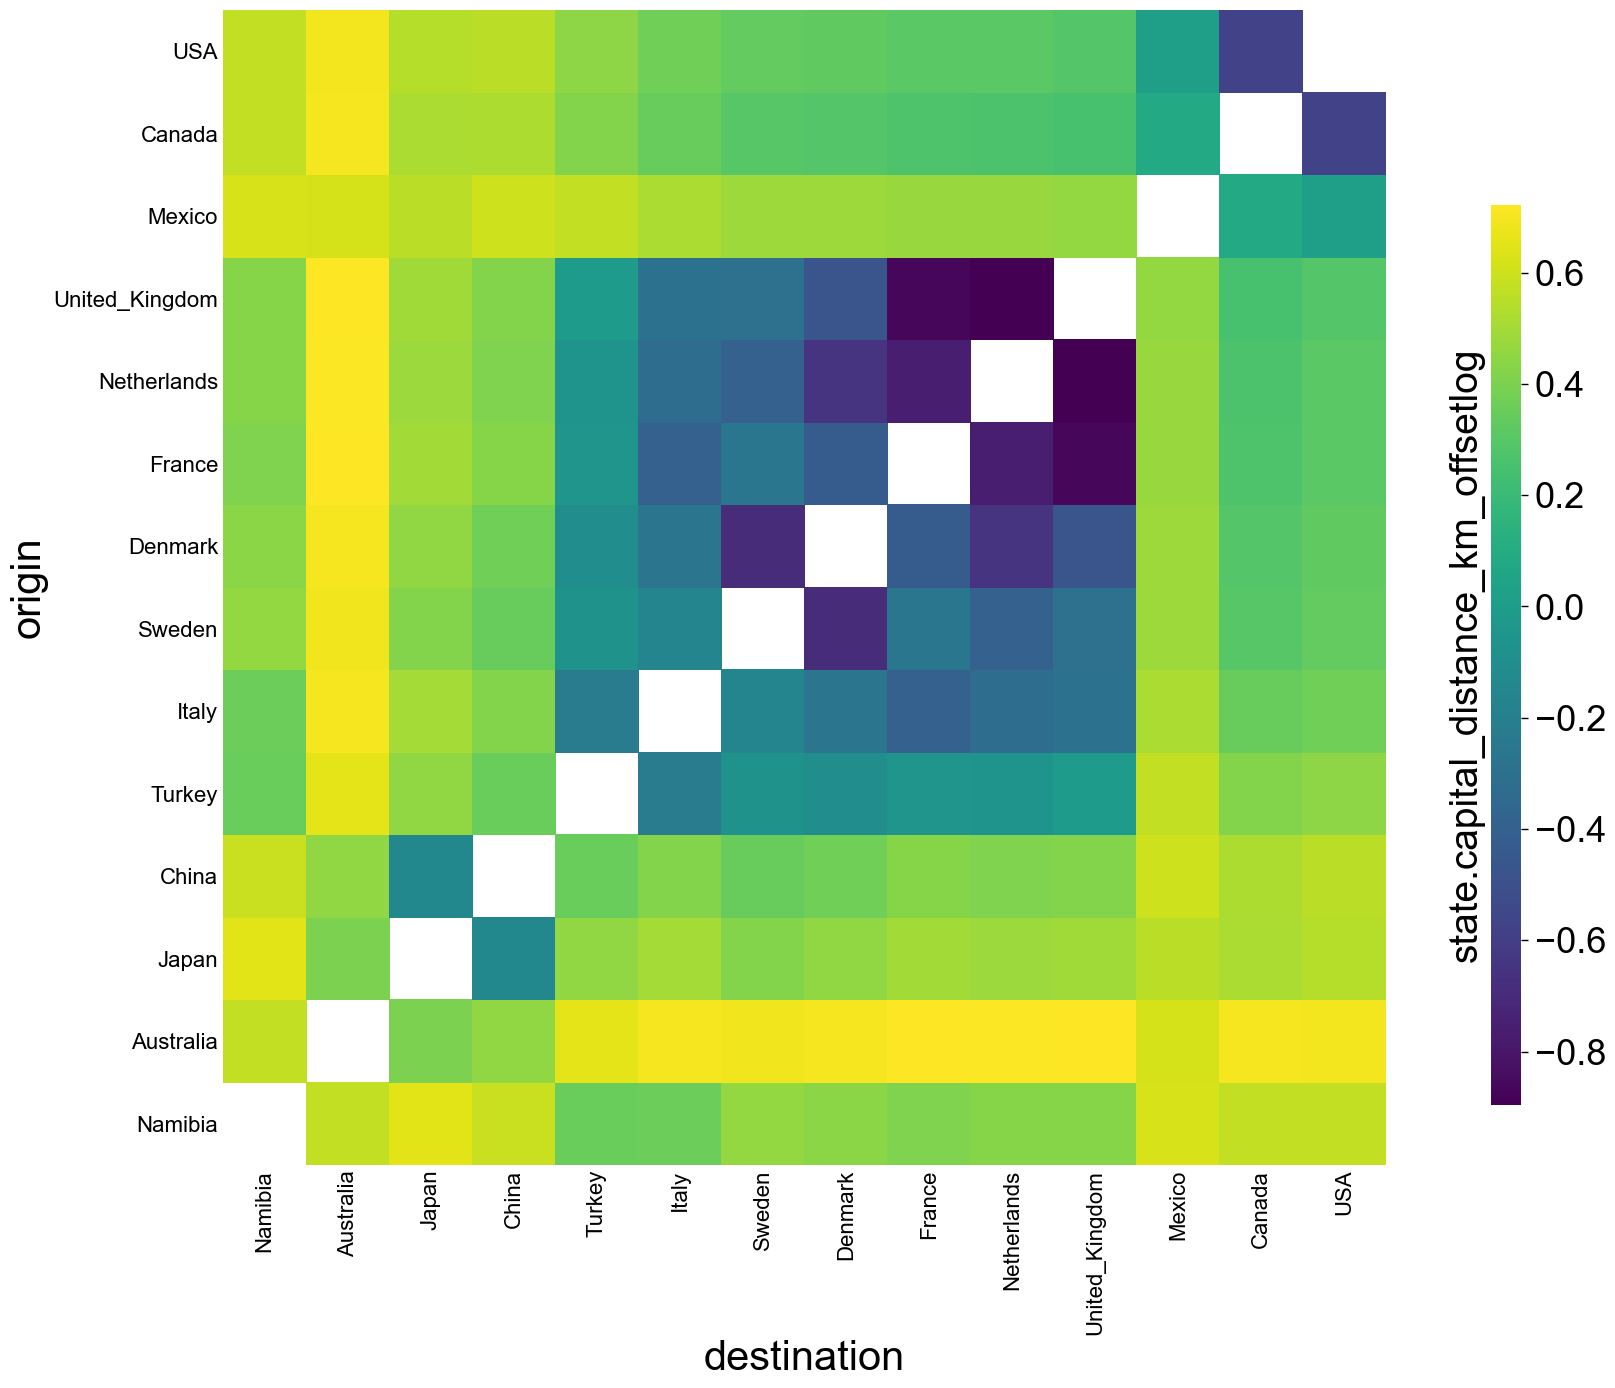

state.continent 42.0


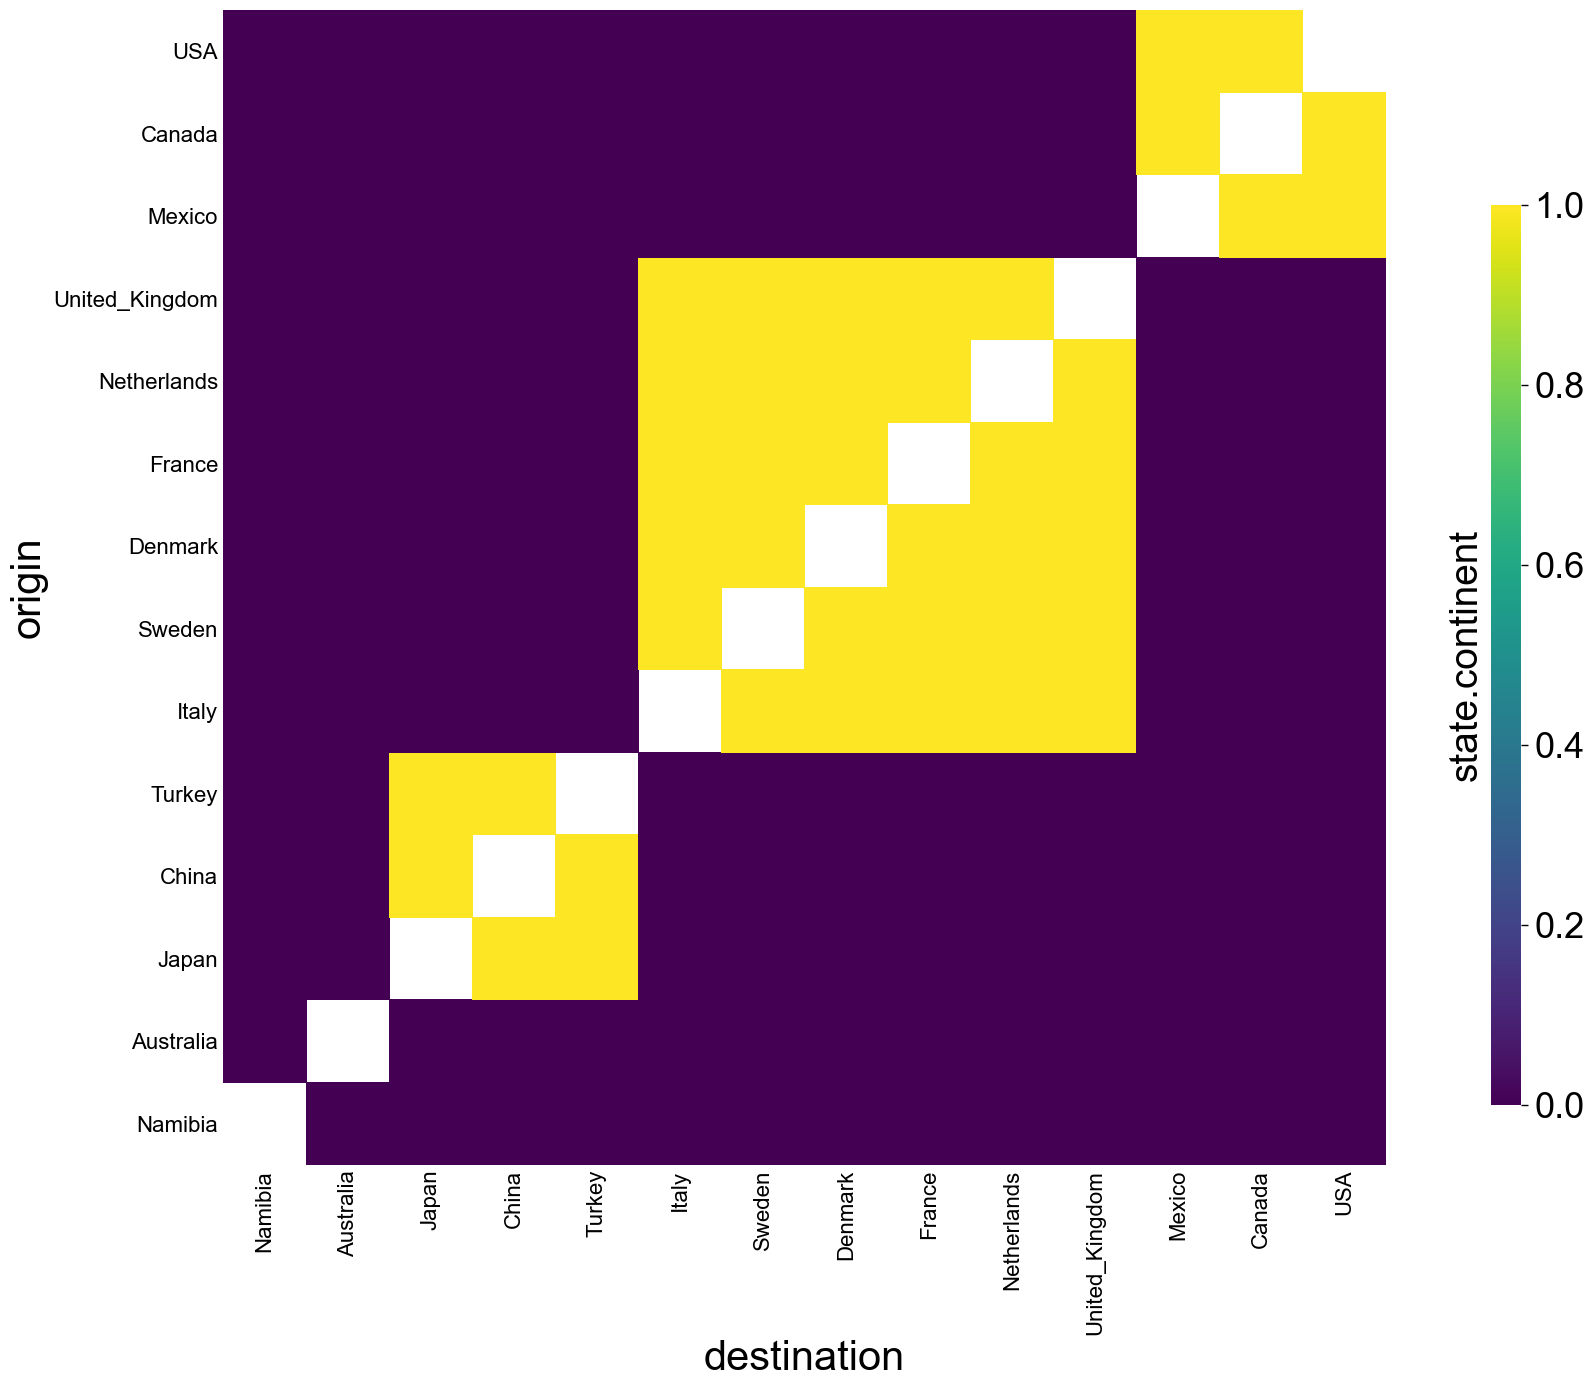

state.land_boarders 6.0


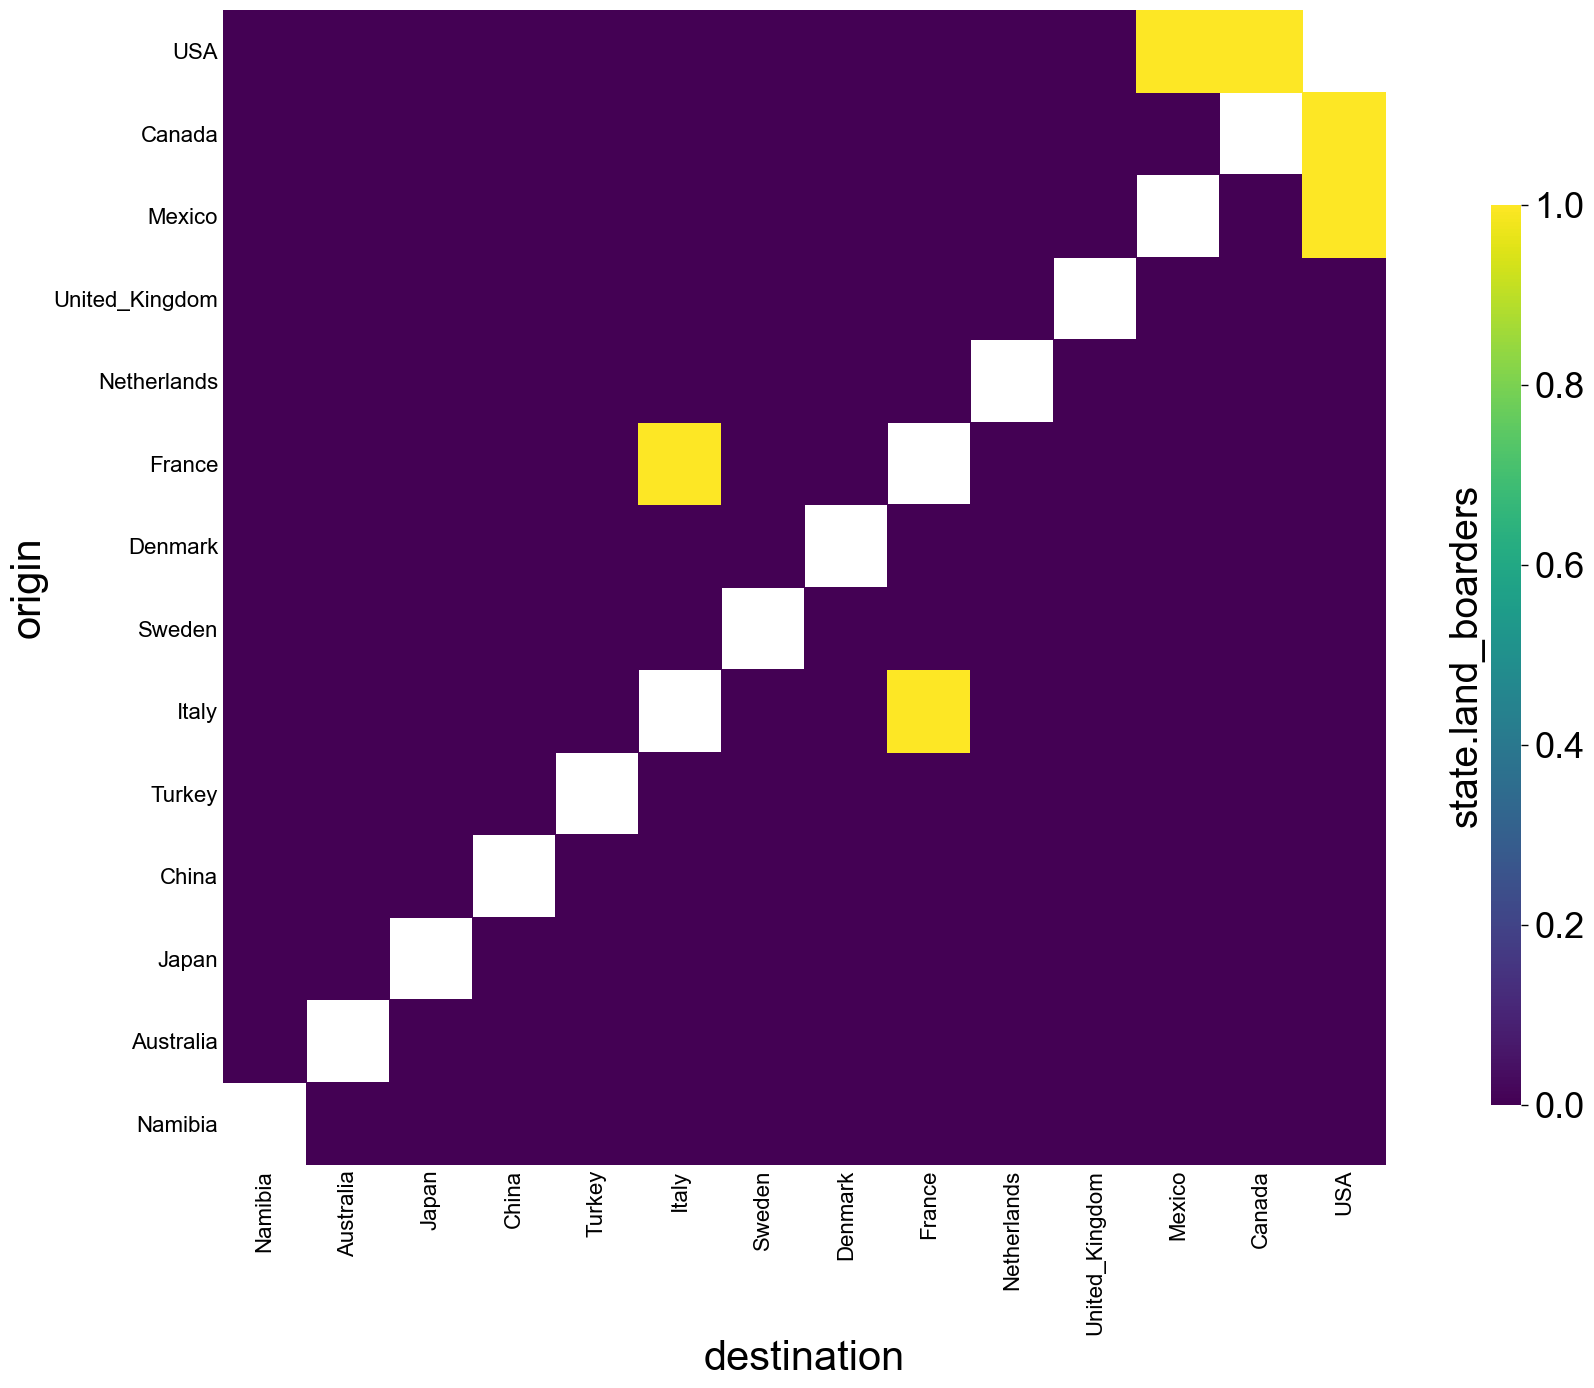

state.cattle_trade_exp_origin_offsetlog 8.109748245925505


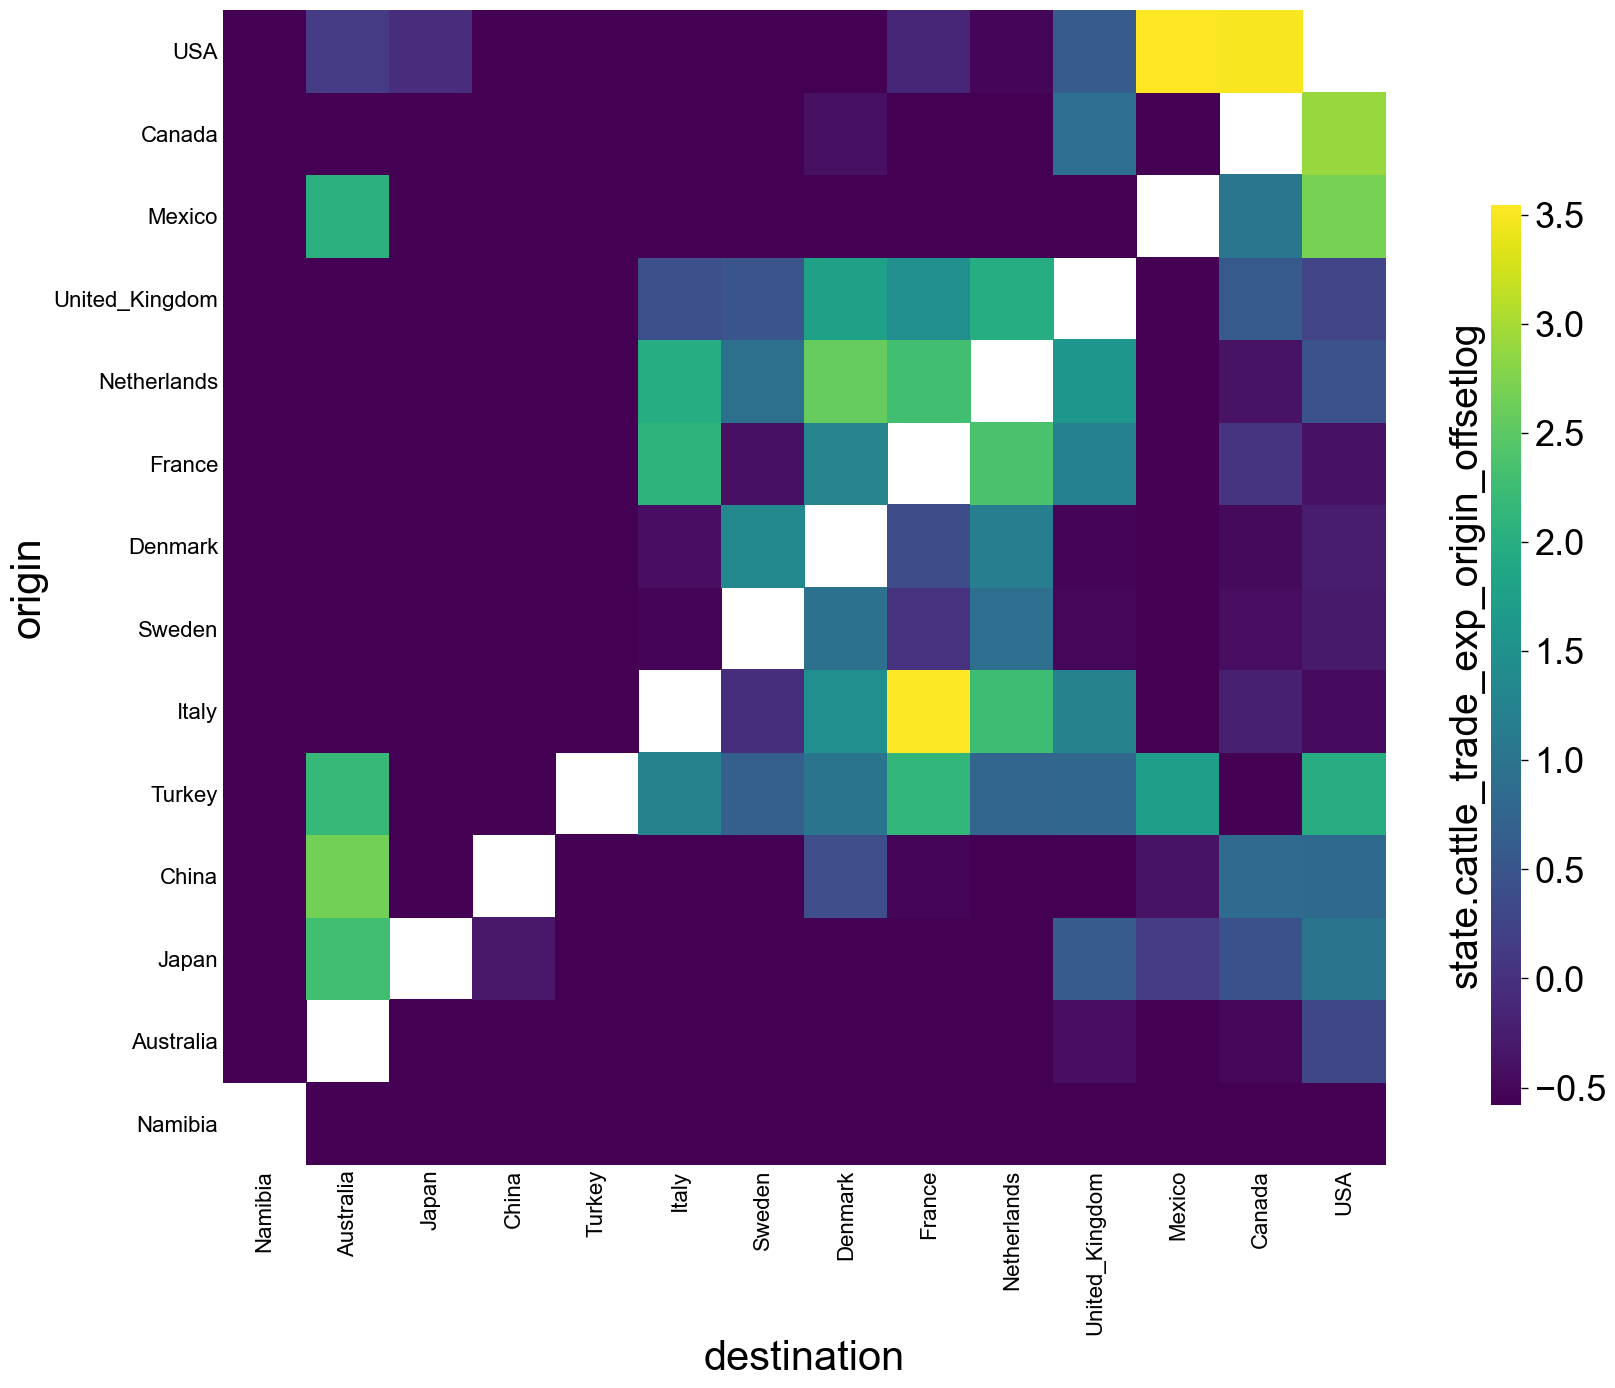

state.swine_trade_exp_origin_offsetlog 8.65977927024883


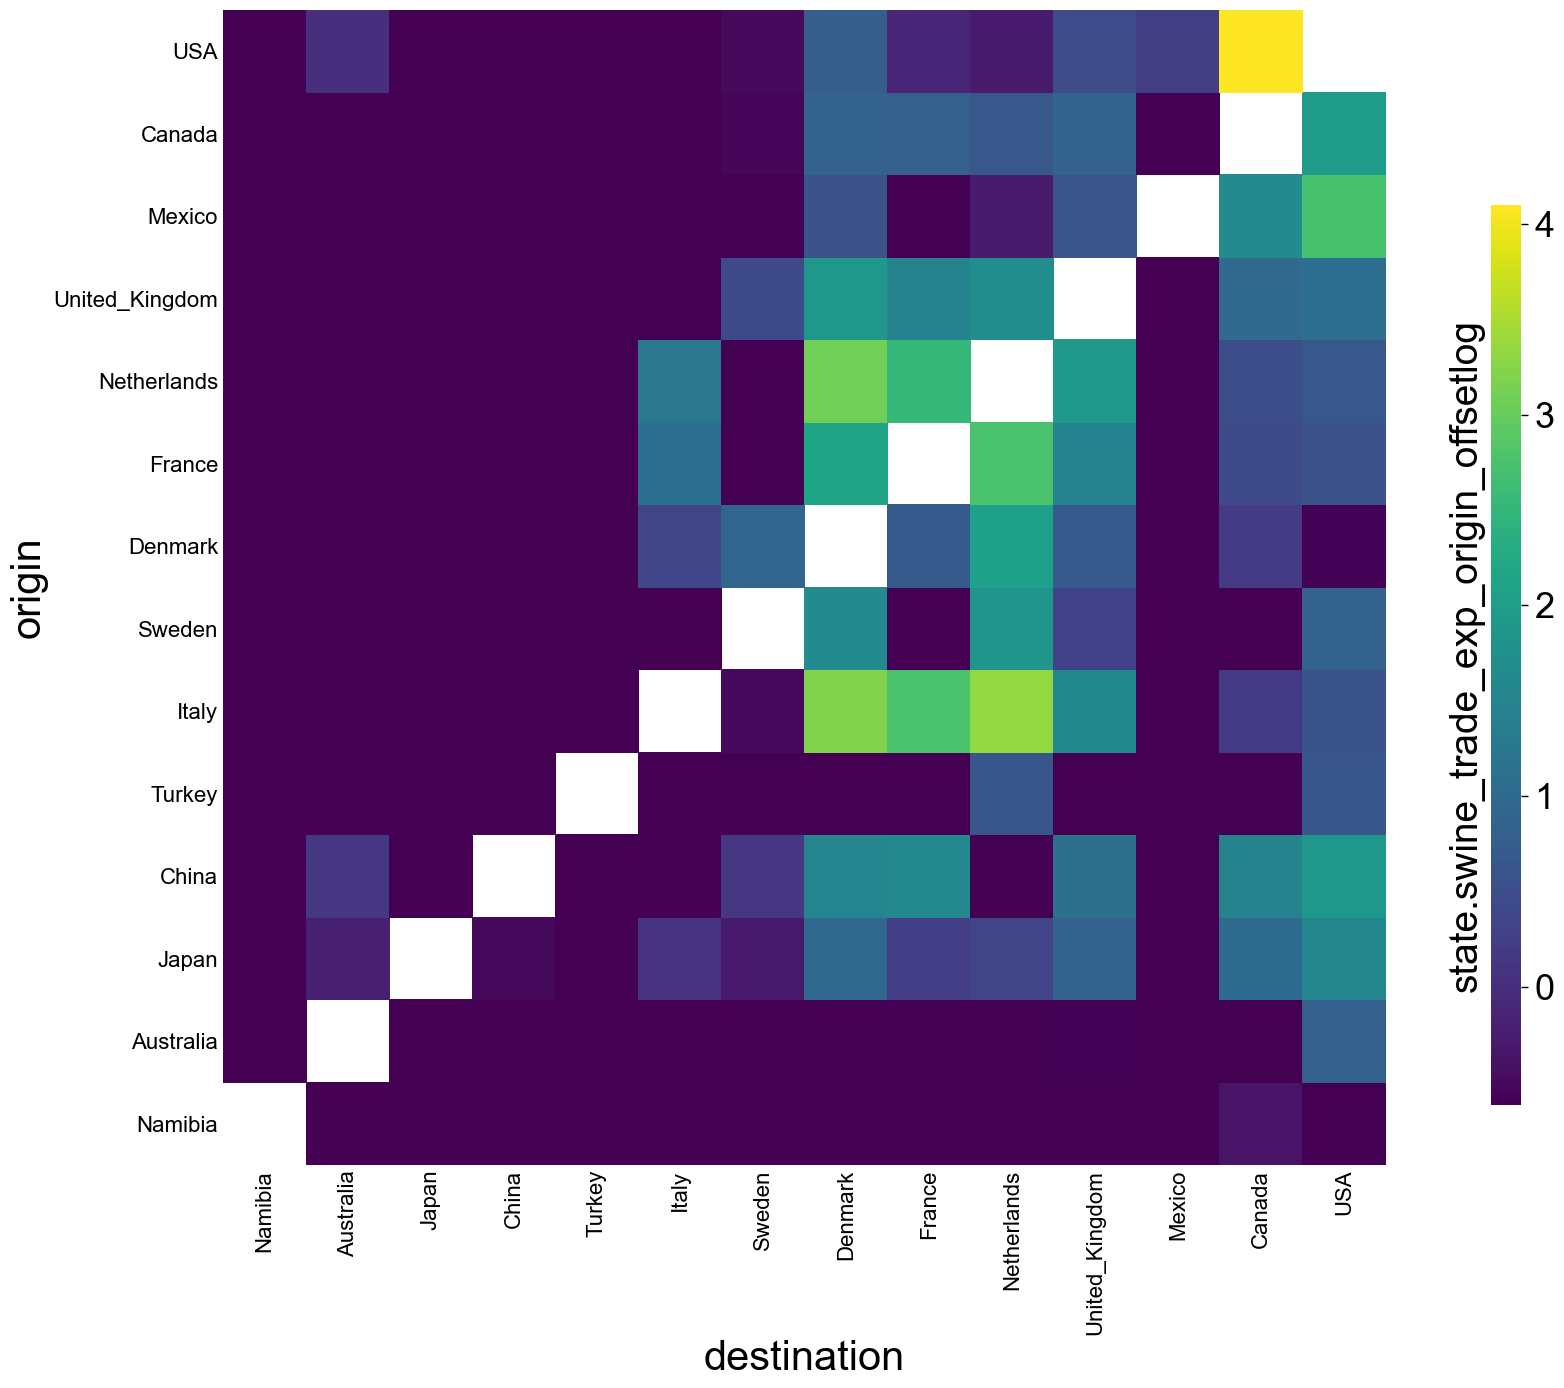

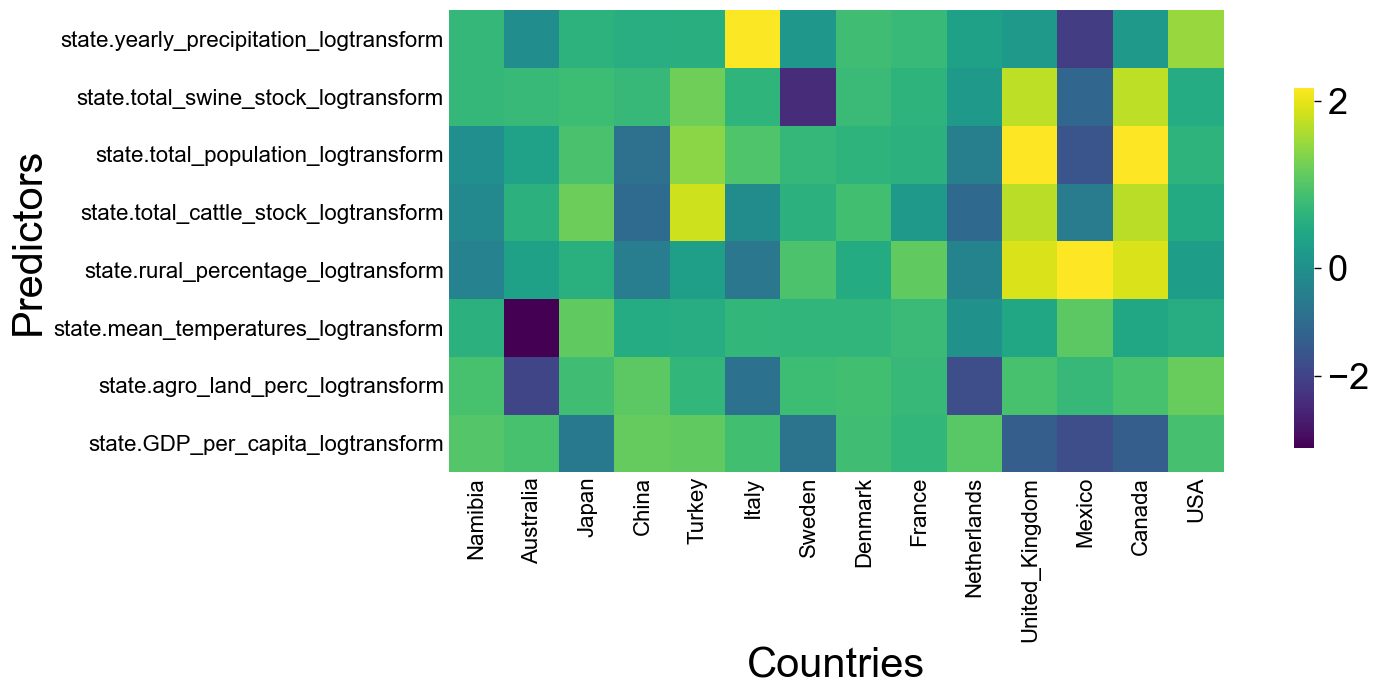

In [3]:
# Set up the color map
cmap = plt.get_cmap('viridis')

sorted_locations=['Namibia', 'Australia', 'Japan', 'China', 'Turkey', 'Italy', 'Sweden', 'Denmark', 'France', 'Netherlands', 'United_Kingdom', 'Mexico', 'Canada', 'USA']
other_pred = {key: [] for key in xml_districts}
keys_list = list(other_pred.keys()) 


# Iterate through predictors in predictor_matrices
for predictor in predictor_matrices.keys():
    # Skip predictors related to "destination" or "origin"
    if 'dest' not in predictor and 'origin' not in predictor or 'trade' in predictor and 'dest' not in predictor:
        # Initialize an empty matrix filled with NaNs
        empty = np.zeros((len(xml_districts), len(xml_districts)))
        empty.fill(np.nan)
        analysis = pd.DataFrame(empty, index=sorted_locations, columns=sorted_locations)
        
        # Start figure
        fig, ax = plt.subplots(figsize=(15, 15), facecolor='w')

        # Iterate over predictor values and fill the analysis matrix
        for ind, value in enumerate(predictor_matrices[predictor]):
            ori, dest = matrix_index[ind]
                
            # Assign the value to the correct position in the matrix
            analysis.loc[dest, ori] = value

        # Mask NaNs in the analysis matrix
        masked_array = np.ma.array(np.array(analysis), mask=np.isnan(analysis))

        # Print predictor and the sum of the analysis matrix for debugging
        print(predictor, analysis.sum().sum())
        
        # Configure the color map for handling NaN values
        cmap.set_bad('k', 1.0)

        # Plot the heatmap
        heatmap = ax.pcolor(masked_array, edgecolors='none', linewidths=0, cmap=cmap, alpha=1)

        # Customize the plot's appearance
        ax.set_xticks(np.arange(0.5, len(sorted_locations) + 0.5))
        ax.set_xticklabels([x for x in sorted_locations], rotation=90)
        ax.set_yticks(np.arange(0.5, len(sorted_locations) + 0.5))
        ax.set_yticklabels([x for x in sorted_locations])
        ax.set_xlabel('destination', size=30)
        ax.set_ylabel('origin', size=30)
        ax.tick_params(size=0, labelsize=16)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # Add the colorbar
        axcb = fig.add_axes([0.97, 0.15, 0.02, 0.6], frame_on=False)
        cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=mpl.colors.Normalize(vmin=min(predictor_matrices[predictor]), vmax=max(predictor_matrices[predictor])), orientation='vertical', alpha=1.0, drawedges=False)

        # Configure colorbar appearance
        axcb.yaxis.set_label_position("left")
        axcb.tick_params(axis='y', which='both', direction='out', size=5, labelsize=26, width=1, pad=5)

        # Use predictor name as colorbar label
        axcb.set_ylabel(f'{predictor}', {'fontsize': 28})

        # Display the plot
        plt.savefig(f'{predictor}.png',dpi=300,bbox_inches='tight')
        plt.show()

    elif "dest" in predictor and "trade" not in predictor:
        for ind, value in enumerate(predictor_matrices[predictor]):
            if ind < 14:
                pred = {predictor: value}
                if keys_list[ind] not in other_pred:
                    other_pred[keys_list[ind]] = []
                other_pred[keys_list[ind]].append(pred)

# Convert the dictionary into a DataFrame
countries = list(other_pred.keys())

all_predictors = set()
for country in countries:
    for entry in other_pred[country]:
        all_predictors.add(list(entry.keys())[0])
predictors = sorted(all_predictors)  # Ensure consistent order


countries = [c for c in sorted_locations if c in countries]
# Construct a uniform DataFrame
heatmap_data = pd.DataFrame(index=predictors, columns=countries)
for country in countries:
    for entry in other_pred[country]:
        for key, value in entry.items():
            heatmap_data.at[key, country] = value

# Convert data to float and handle missing values
heatmap_data = heatmap_data.astype(float).fillna(0)

# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
heatmap = ax.pcolor(heatmap_data, edgecolors='none', linewidths=0, cmap=cmap, alpha=1)

# Customize the plot's appearance
plt.ylabel("Predictors", size=30)
plt.xlabel("Countries", size=30)

predictors = ['_'.join(x.split("_")[:-2]) +"_" + x.split("_")[-1] for x in predictors]

ax.set_xticks(np.arange(0.5, len(countries) + 0.5))
ax.set_xticklabels([x for x in countries], rotation=90)
ax.set_yticks(np.arange(0.5, len(predictors) + 0.5))
ax.set_yticklabels([x for x in predictors])

ax.tick_params(size=0, labelsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add the colorbar
axcb = fig.add_axes([0.97, 0.15, 0.02, 0.6], frame_on=False)

norm = TwoSlopeNorm(vmin=np.min(heatmap_data.values), vcenter=0, vmax=np.max(heatmap_data.values))
cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical', alpha=1.0, drawedges=False)

# Configure colorbar appearance
axcb.yaxis.set_label_position("left")
axcb.tick_params(axis='y', which='both', direction='out', size=5, labelsize=26, width=1, pad=5)

plt.savefig('predictors.png',dpi=300,bbox_inches='tight')
plt.show()


                                              Feature        VIF
0       state.agro_land_perc_destination_logtransform   3.962976
1            state.agro_land_perc_origin_logtransform   3.962976
2                 state.capital_distance_km_offsetlog   2.189345
3                                     state.continent   1.812283
4       state.GDP_per_capita_destination_logtransform   5.997416
5            state.GDP_per_capita_origin_logtransform   5.997416
6                                 state.land_boarders   2.149155
7     state.rural_percentage_destination_logtransform   6.591822
8          state.rural_percentage_origin_logtransform   6.591822
9   state.total_cattle_stock_destination_logtransform  10.842369
10       state.total_cattle_stock_origin_logtransform  10.842369
11    state.total_population_destination_logtransform  16.726563
12         state.total_population_origin_logtransform  16.726563
13   state.total_swine_stock_destination_logtransform   2.467842
14        state.total_swi

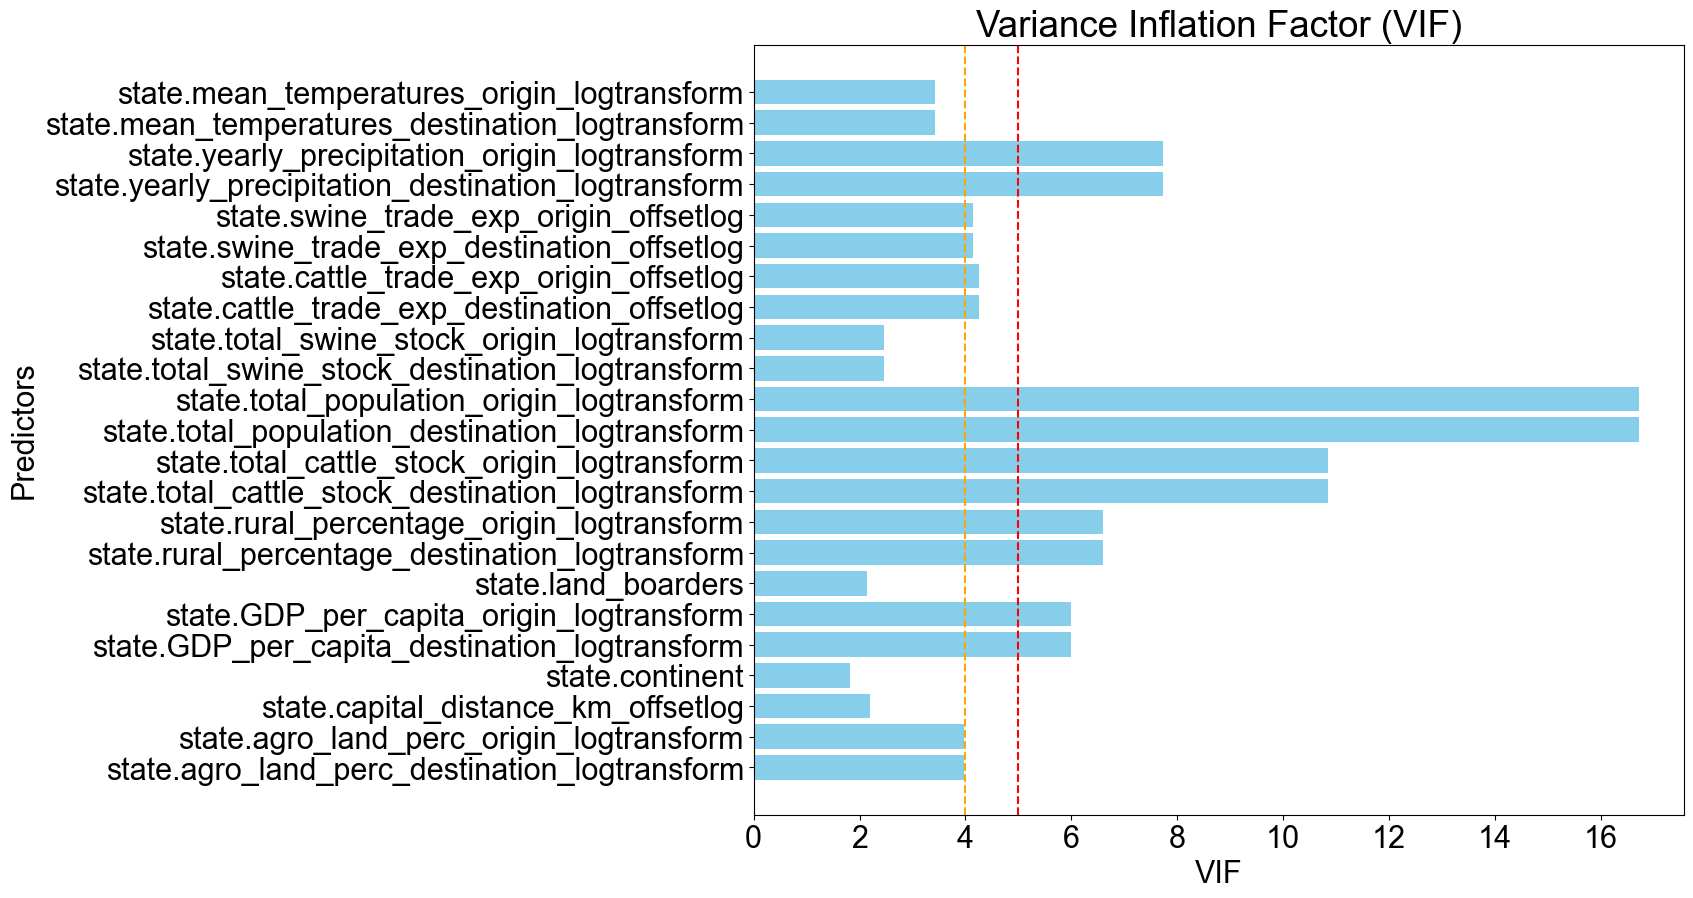

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr

# Create a DataFrame from your predictor matrices
required = list(predictor_matrices.keys())
X = pd.DataFrame({key: predictor_matrices[key] for key in required})  # Ensure X contains all the required predictors

# calculate VIF

vif_results = pd.DataFrame()
vif_results["Feature"] = X.columns
vif_results["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF results
print(vif_results)

# Plot the VIF results
plt.figure(figsize=(12, 10))
plt.barh(vif_results['Feature'], vif_results['VIF'], color='skyblue')
plt.axvline(x=4, color='orange', linestyle='--')  # Common VIF threshold
plt.axvline(x=5, color='red', linestyle='--')  # Common VIF threshold
plt.title('Variance Inflation Factor (VIF)')
plt.xlabel('VIF')
plt.ylabel('Predictors')
plt.show()



C:\Users\iblag\AppData\Local\Temp\ipykernel_15624\3941791428.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axcb.set_yticklabels(axcb.get_yticklabels(), size=32, family='serif')  # 'serif' as an example


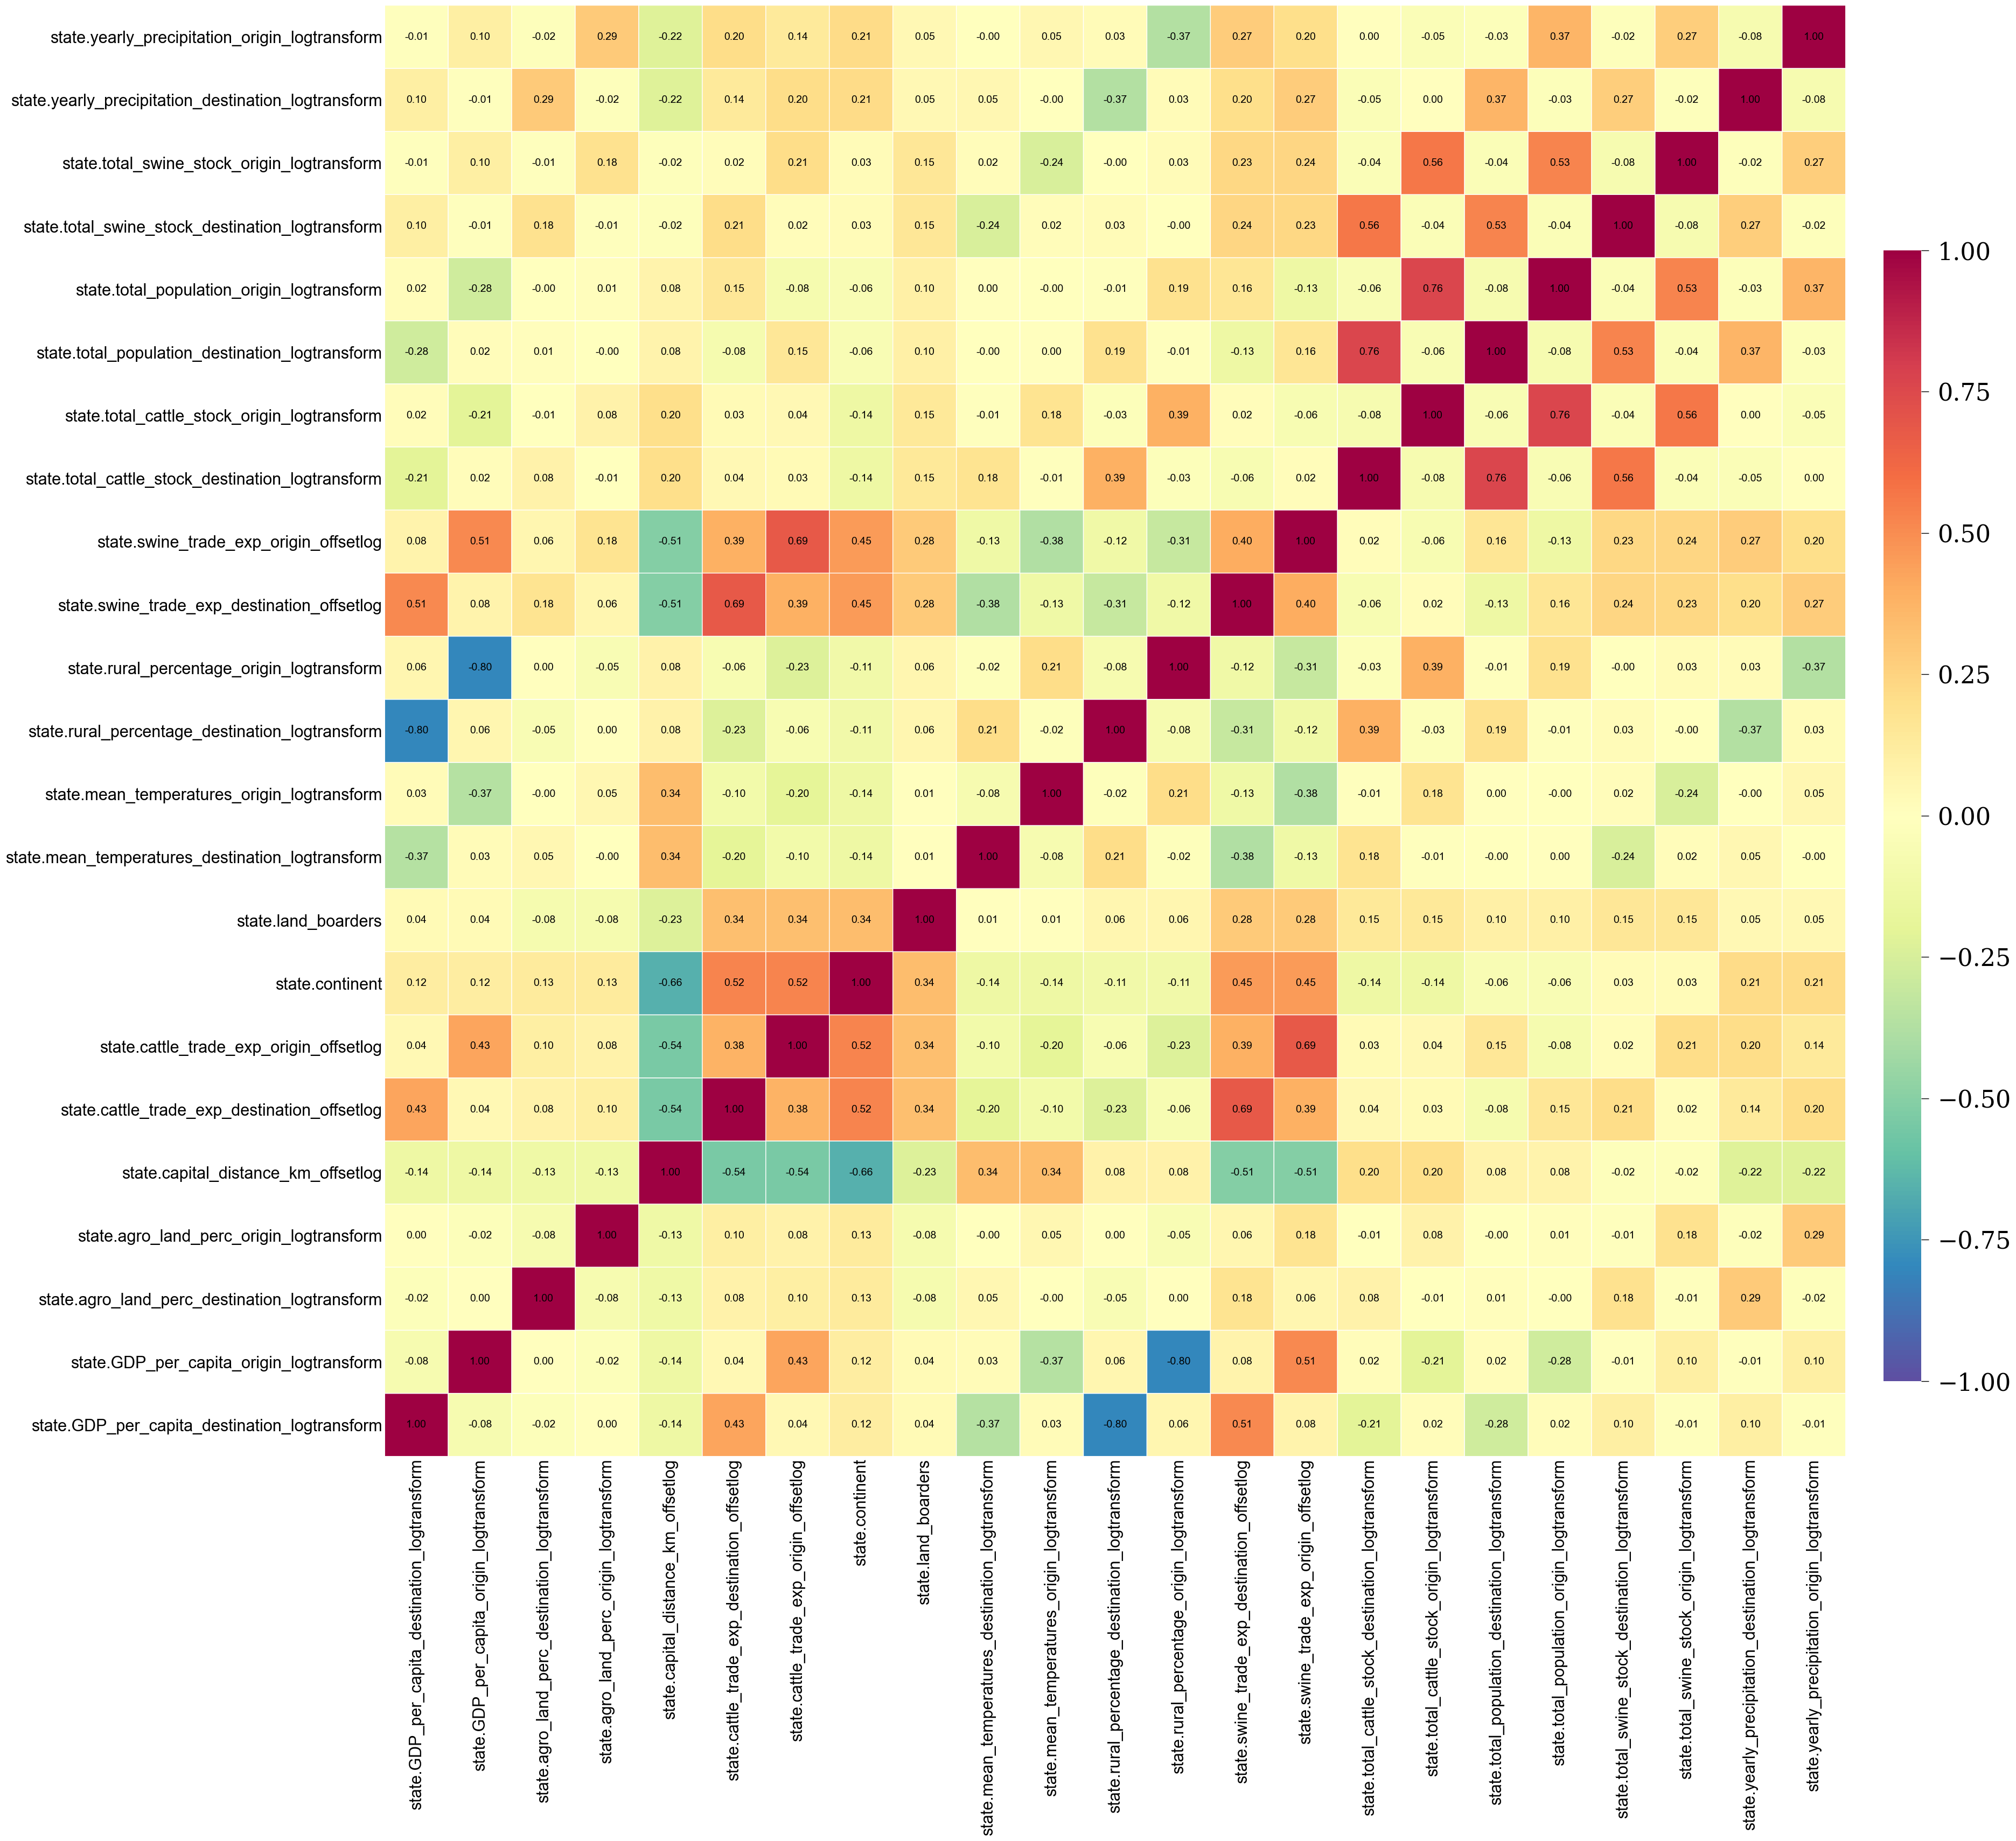

In [5]:
required = list(predictor_matrices.keys())

cmap = plt.get_cmap('Spectral_r') 

# Start figure
fig, ax = plt.subplots(figsize=(35, 35), facecolor='w')

sorted_required = sorted(required, key=lambda x: x)

empty = np.zeros((len(sorted_required), len(sorted_required)))
empty.fill(np.nan)
analysis = pd.DataFrame(empty, index=sorted_required, columns=sorted_required)

for i, predictorA in enumerate(required):
    # Print progress
    # print('%30s%10.2f' % (predictorA, i / float(len(required))))
    for j, predictorB in enumerate(required):

        matrixA = predictor_matrices[predictorA]
        matrixB = predictor_matrices[predictorB]
        
        coeff, pvalue = spearmanr(matrixA, matrixB)
        analysis.loc[predictorA, predictorB] = coeff

        # Use ax.text() to place the coefficient values on the heatmap
        ax.text(
            sorted_required.index(predictorA) + 0.5,
            sorted_required.index(predictorB) + 0.5,
            f'{coeff:.2f}',
            size=14, va='center', ha='center'
        )

masked_array = np.ma.array(np.array(analysis), mask=np.isnan(analysis))

# Plot heatmap of the predictor matrix
heatmap = ax.pcolor(
    masked_array, edgecolors='w', linewidths=1,
    cmap=cmap, alpha=1, norm=mpl.colors.Normalize(-1, 1)
)

# Make plot pretty
ax.set_xticks(np.arange(0.5, len(required) + 0.5))
ax.set_yticks(np.arange(0.5, len(required) + 0.5))
ax.set_xticklabels(sorted_required, rotation=90)
ax.set_yticklabels(sorted_required)
ax.set_xlim(0, len(required))
ax.set_ylim(0, len(required))
ax.tick_params(size=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Add colorbar
axcb = fig.add_axes([0.92, 0.15, 0.02, 0.6], frame_on=False)
cb = mpl.colorbar.ColorbarBase(
    axcb, cmap=cmap, norm=mpl.colors.Normalize(vmin=-1, vmax=1),
    orientation='vertical', alpha=1.0, drawedges=False
)

# Configure colorbar appearance
axcb.yaxis.set_label_position("left")
axcb.tick_params(axis='y', which='both', direction='out', size=12, width=1, pad=10)
for tick in axcb.yaxis.get_ticklines():
    tick.set_markersize(10)

# Set colorbar tick labels' font properties
axcb.set_yticklabels(axcb.get_yticklabels(), size=32, family='serif')  # 'serif' as an example

plt.show()
